# Unit14 超參數調整：Grid Search v2 | Hyperparameter Tuning: Grid Search v2

**逢甲大學 化學工程學系**  
**課程名稱**: AI在化工上之應用  
**課程代碼**: CHE-AI-114  
**授課教師**: 莊曜禎 助理教授

---

## 📚 學習目標

本程式演練展示 Grid Search 在**小樣本高噪聲場景**下的顯著優化效果：

1. **小數據集挑戰**: 理解樣本不足時超參數調整的重要性
2. **過擬合控制**: 學習如何透過超參數調整平衡模型複雜度
3. **噪聲數據處理**: 觀察正則化參數對高噪聲數據的影響
4. **顯著性能提升**: 體驗 Grid Search 在適當場景下的優化效果
5. **基準對比**: 了解不同初始配置對優化結果的影響

## 📋 案例背景

**場景**: 新型催化劑篩選實驗的產率預測

**問題描述**:
- **小樣本挑戰**: 僅有 500 個實驗數據點（催化劑合成成本高昂）
- **高噪聲環境**: 實驗條件控制困難，測量誤差較大
- **複雜關係**: 催化劑組分間存在非線性交互作用
- **過擬合風險**: 樣本少+特徵多容易導致過擬合

**輸入變數**:
- 主催化劑負載量（Catalyst_A, wt%）
- 助催化劑負載量（Catalyst_B, wt%）
- 載體比表面積（Support_Area, m²/g）
- 反應溫度（Temperature, °C）
- 反應壓力（Pressure, bar）

**輸出變數**: 目標產物產率（Yield, %）

**為什麼這個場景適合 Grid Search？**
1. **小樣本** → 模型容易過擬合，需要精細的正則化調整
2. **高噪聲** → 需要找到最佳的 min_samples_leaf 和 min_samples_split
3. **預設參數不適用** → Random Forest 預設值是為大數據集設計的

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit14_Hyperparameter_Tuning_GridSearch_v2'
SOURCE_DATA_DIR = 'catalyst_screening'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit14'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\catalyst_screening
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch_v2
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch_v2\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch_v2\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Sklearn 模型與工具
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

# 設定視覺化風格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_style("whitegrid")

print("=" * 60)
print("套件載入完成")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"隨機種子: {SEED}")
print("=" * 60)

套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
TensorFlow version: 2.10.1
隨機種子: 42


---
## 2. 數據生成（小樣本高噪聲場景）

模擬新型催化劑篩選實驗：
- **樣本數**: 500（遠小於 v1 的 5000）
- **噪聲水平**: 中等偏高（模擬實驗誤差，但保持可學習性）
- **數據特性**: 非線性、交互作用、測量誤差
- **產率分布**: 主要集中在 60-90%（符合實際實驗情況）
- **Clipping 控制**: < 1% 數據被 clip（保持數據真實性）
- **可學習性**: 特徵與目標有明確的關聯性，適合展示 Grid Search 效果

In [3]:
def generate_catalyst_screening_data(n_samples=500, noise_level='high', random_state=42):
    """
    生成催化劑篩選實驗數據（小樣本、高噪聲）
    
    Parameters:
    -----------
    n_samples : int
        樣本數量（建議 500-1000，模擬小規模實驗）
    noise_level : str
        噪聲等級：'low', 'medium', 'high'
    random_state : int
        隨機種子
    
    Returns:
    --------
    X : DataFrame
        特徵數據
    y : ndarray
        目標變數（產率）
    """
    np.random.seed(random_state)
    
    # 生成特徵（催化劑篩選實驗參數）
    catalyst_a = np.random.uniform(0.5, 5.0, n_samples)  # 主催化劑負載量 (wt%)
    catalyst_b = np.random.uniform(0.1, 2.0, n_samples)  # 助催化劑負載量 (wt%)
    support_area = np.random.uniform(100, 500, n_samples)  # 載體比表面積 (m²/g)
    temperature = np.random.uniform(150, 300, n_samples)  # 反應溫度 (°C)
    pressure = np.random.uniform(5, 30, n_samples)  # 反應壓力 (bar)
    
    X = pd.DataFrame({
        'Catalyst_A': catalyst_a,
        'Catalyst_B': catalyst_b,
        'Support_Area': support_area,
        'Temperature': temperature,
        'Pressure': pressure
    })
    
    # 生成目標變數（產率）- 複雜非線性關係
    # 主效應（增強特徵影響力，確保模型可學習）
    cat_a_effect = 12 * np.log(catalyst_a + 1) - 0.5 * catalyst_a ** 2
    cat_b_effect = 10 * np.sqrt(catalyst_b) - 1.5 * catalyst_b ** 2
    area_effect = 0.06 * support_area - 0.00006 * support_area ** 2
    temp_effect = 0.20 * temperature - 0.0004 * temperature ** 2
    pressure_effect = 1.0 * pressure - 0.015 * pressure ** 2
    
    # 交互作用（催化劑間的協同效應 - 增強）
    cat_synergy = 2.5 * catalyst_a * catalyst_b / (catalyst_a + catalyst_b + 0.1)
    area_cat_interact = 0.004 * support_area * np.sqrt(catalyst_a)
    temp_pressure_interact = 0.0008 * temperature * pressure
    
    # 基礎產率
    yield_rate = (
        cat_a_effect + cat_b_effect + area_effect + temp_effect + pressure_effect +
        cat_synergy + area_cat_interact + temp_pressure_interact + 5
    )
    
    # 添加噪聲（模擬實驗誤差 - 降低噪聲以提高可學習性）
    noise_levels = {
        'low': 2.0,
        'medium': 4.0,
        'high': 6.0  # 從 10.0 降低到 6.0
    }
    noise_std = noise_levels.get(noise_level, 4.0)
    
    # 主要噪聲（測量誤差）
    measurement_noise = np.random.normal(0, noise_std, n_samples)
    
    # 系統性偏差（減少溫度相關的偏差）
    systematic_bias = np.random.normal(0, 0.01 * temperature, n_samples)
    
    # 隨機異常值（減少異常值的影響）
    n_outliers = int(0.03 * n_samples)  # 從 5% 降低到 3%
    outlier_idx = np.random.choice(n_samples, n_outliers, replace=False)
    outlier_noise = np.zeros(n_samples)
    outlier_noise[outlier_idx] = np.random.uniform(-15, 15, n_outliers)  # 從 ±20 降低到 ±15
    
    total_noise = measurement_noise + systematic_bias + outlier_noise
    yield_rate += total_noise
    
    # 限制在合理範圍內
    y = np.clip(yield_rate, 0, 100)
    
    return X, y

# 生成數據（小樣本、高噪聲）
X, y = generate_catalyst_screening_data(n_samples=500, noise_level='high', random_state=42)

print("=" * 60)
print("Data Generation Summary (Small Sample, High Noise)")
print("=" * 60)
print(f"Total samples: {len(X)} (⚠️ 小樣本場景)")
print(f"Number of features: {X.shape[1]}")
print(f"Samples per feature: {len(X) / X.shape[1]:.1f} (建議 > 100)")
print(f"\nFeature names: {list(X.columns)}")
print(f"\nTarget variable (Yield) statistics:")
print(f"  Mean: {y.mean():.2f}%")
print(f"  Std: {y.std():.2f}% (⚠️ 中等標準差表示適度噪聲)")
print(f"  Min: {y.min():.2f}%")
print(f"  Max: {y.max():.2f}%")
print(f"  Coefficient of Variation: {y.std()/y.mean()*100:.1f}%")
print(f"  Clipping at 100%: {(y == 100).sum()} samples ({(y == 100).sum()/len(y)*100:.1f}%)")
print(f"  Clipping at 0%: {(y == 0).sum()} samples ({(y == 0).sum()/len(y)*100:.1f}%)")
print("=" * 60)

Data Generation Summary (Small Sample, High Noise)
Total samples: 500 (⚠️ 小樣本場景)
Number of features: 5
Samples per feature: 100.0 (建議 > 100)

Feature names: ['Catalyst_A', 'Catalyst_B', 'Support_Area', 'Temperature', 'Pressure']

Target variable (Yield) statistics:
  Mean: 77.74%
  Std: 9.52% (⚠️ 中等標準差表示適度噪聲)
  Min: 41.74%
  Max: 100.00%
  Coefficient of Variation: 12.2%
  Clipping at 100%: 2 samples (0.4%)
  Clipping at 0%: 0 samples (0.0%)


---
## 3. 數據分割

由於樣本數較少，使用 60%/20%/20% 分割。

In [4]:
# 分割數據集: 60% 訓練, 20% 驗證, 20% 測試
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.80 = 0.20
)

print("=" * 60)
print("Data Split Summary")
print("=" * 60)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n⚠️ 訓練樣本數 ({len(X_train)}) 相對較少，模型容易過擬合")
print("=" * 60)

Data Split Summary
Training set: 300 samples (60.0%)
Validation set: 100 samples (20.0%)
Test set: 100 samples (20.0%)

⚠️ 訓練樣本數 (300) 相對較少，模型容易過擬合


---
## 4. 基準模型（使用不適當的配置）

為了展示 Grid Search 的優化效果，我們故意使用一個**不適合小樣本場景**的配置：
- `n_estimators=50`（樹太少，欠擬合）
- `max_depth=None`（深度不限，易過擬合）
- `min_samples_split=2`（分裂太容易，過擬合）
- `min_samples_leaf=1`（葉節點可以只有 1 個樣本，過擬合）

這個配置會讓模型在小數據集上表現不佳，Grid Search 將有機會找到更好的參數組合。

In [5]:
# 訓練基準模型（故意使用不適當的配置）
baseline_model = RandomForestRegressor(
    n_estimators=50,  # 較少的樹（可能欠擬合）
    max_depth=None,  # 不限制深度（可能過擬合）
    min_samples_split=2,  # 最小分裂樣本數（容易過擬合）
    min_samples_leaf=1,  # 最小葉節點樣本數（容易過擬合）
    random_state=42
)
baseline_model.fit(X_train, y_train)

# 評估基準模型
y_train_pred_baseline = baseline_model.predict(X_train)
y_val_pred_baseline = baseline_model.predict(X_val)

baseline_train_r2 = r2_score(y_train, y_train_pred_baseline)
baseline_val_r2 = r2_score(y_val, y_val_pred_baseline)
baseline_train_mae = mean_absolute_error(y_train, y_train_pred_baseline)
baseline_val_mae = mean_absolute_error(y_val, y_val_pred_baseline)

# 計算過擬合程度
overfit_gap_r2 = baseline_train_r2 - baseline_val_r2
overfit_gap_mae = baseline_val_mae - baseline_train_mae

print("=" * 60)
print("Baseline Model Performance (Suboptimal Configuration)")
print("=" * 60)
print(f"Configuration: n_estimators=50, max_depth=None, ")
print(f"               min_samples_split=2, min_samples_leaf=1")
print()
print(f"Training R²:   {baseline_train_r2:.4f}")
print(f"Validation R²: {baseline_val_r2:.4f}")
print(f"Training MAE:  {baseline_train_mae:.4f}%")
print(f"Validation MAE: {baseline_val_mae:.4f}%")
print()
print(f"⚠️ 過擬合檢測:")
print(f"   R² gap (Train - Val): {overfit_gap_r2:.4f} {'(過擬合!)' if overfit_gap_r2 > 0.10 else ''}")
print(f"   MAE gap (Val - Train): {overfit_gap_mae:.4f}% {'(過擬合!)' if overfit_gap_mae > 2 else ''}")
print("=" * 60)

Baseline Model Performance (Suboptimal Configuration)
Configuration: n_estimators=50, max_depth=None, 
               min_samples_split=2, min_samples_leaf=1

Training R²:   0.9297
Validation R²: 0.4708
Training MAE:  2.0833%
Validation MAE: 5.4801%

⚠️ 過擬合檢測:
   R² gap (Train - Val): 0.4589 (過擬合!)
   MAE gap (Val - Train): 3.3968% (過擬合!)


---
## 5. Grid Search 超參數網格設定

針對**小樣本高噪聲場景**，設計專門的搜索範圍：
- **n_estimators**: [100, 200, 300] - 增加樹的數量以提升穩定性
- **max_depth**: [5, 10, 15, 20] - 限制深度以防止過擬合
- **min_samples_split**: [5, 10, 20, 30] - 提高分裂門檻
- **min_samples_leaf**: [3, 5, 10, 15] - 增加葉節點樣本數

這些參數範圍專門針對小數據集的過擬合問題。

In [6]:
# 定義超參數網格（針對小樣本高噪聲場景）
param_grid = {
    'n_estimators': [100, 200, 300],  # 增加樹的數量
    'max_depth': [5, 10, 15, 20],  # 限制深度防止過擬合
    'min_samples_split': [5, 10, 20, 30],  # 提高分裂門檻
    'min_samples_leaf': [3, 5, 10, 15]  # 增加葉節點樣本數
}

# 計算搜索空間大小
total_combinations = 1
for param, values in param_grid.items():
    total_combinations *= len(values)

print("=" * 60)
print("Grid Search Configuration (Small Sample Optimized)")
print("=" * 60)
print("Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {total_combinations}")
print("Cross-validation folds: 5")
print(f"Total model fits: {total_combinations * 5}")
print(f"\n💡 設計理念: 所有參數都偏向更強的正則化")
print(f"   以應對小樣本場景的過擬合風險")
print("=" * 60)

Grid Search Configuration (Small Sample Optimized)
Hyperparameter Grid:
  n_estimators: [100, 200, 300]
  max_depth: [5, 10, 15, 20]
  min_samples_split: [5, 10, 20, 30]
  min_samples_leaf: [3, 5, 10, 15]

Total combinations: 192
Cross-validation folds: 5
Total model fits: 960

💡 設計理念: 所有參數都偏向更強的正則化
   以應對小樣本場景的過擬合風險


---
## 6. 執行 Grid Search

使用 5 折交叉驗證，評估指標為 R²。

In [7]:
# 建立 GridSearchCV 對象
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# 執行 Grid Search
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print("\n" + "=" * 60)
print("Grid Search Completed")
print("=" * 60)
print(f"Total time: {end_time - start_time:.2f} seconds")
print(f"Best cross-validation R²: {grid_search.best_score_:.4f}")
print(f"\nBest hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print("=" * 60)

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Grid Search Completed
Total time: 21.62 seconds
Best cross-validation R²: 0.4862

Best hyperparameters:
  max_depth: 15
  min_samples_leaf: 5
  min_samples_split: 5
  n_estimators: 100


---
## 7. Grid Search 結果分析

In [8]:
# 將 Grid Search 結果轉換成 DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# 選擇關鍵列
key_columns = [col for col in results_df.columns if col.startswith('param_')] + \
              ['mean_test_score', 'std_test_score', 'rank_test_score', 'mean_fit_time']

results_summary = results_df[key_columns].sort_values('rank_test_score')

print("=" * 90)
print("Top 10 Hyperparameter Combinations")
print("=" * 90)
print(results_summary.head(10).to_string(index=False))
print("=" * 90)

# 分析最佳與最差的性能差異
best_score = results_df['mean_test_score'].max()
worst_score = results_df['mean_test_score'].min()
print(f"\n📊 性能範圍分析:")
print(f"   最佳 R²: {best_score:.4f}")
print(f"   最差 R²: {worst_score:.4f}")
print(f"   差異: {best_score - worst_score:.4f} ({(best_score - worst_score)/worst_score*100:.1f}% 相對改善)")
print(f"\n💡 超參數選擇對小樣本場景影響顯著！")

Top 10 Hyperparameter Combinations
 param_max_depth  param_min_samples_leaf  param_min_samples_split  param_n_estimators  mean_test_score  std_test_score  rank_test_score  mean_fit_time
              15                       5                        5                 100         0.486228        0.060973                1       0.323320
              20                       5                       10                 100         0.486228        0.060973                1       0.286310
              20                       5                        5                 100         0.486228        0.060973                1       0.249107
              15                       5                       10                 100         0.486228        0.060973                1       0.284603
              10                       5                        5                 100         0.486151        0.060844                5       0.256080
              10                       5                   

---
## 8. 超參數影響視覺化


✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch_v2\figs\01_hyperparameter_heatmaps_v2.png


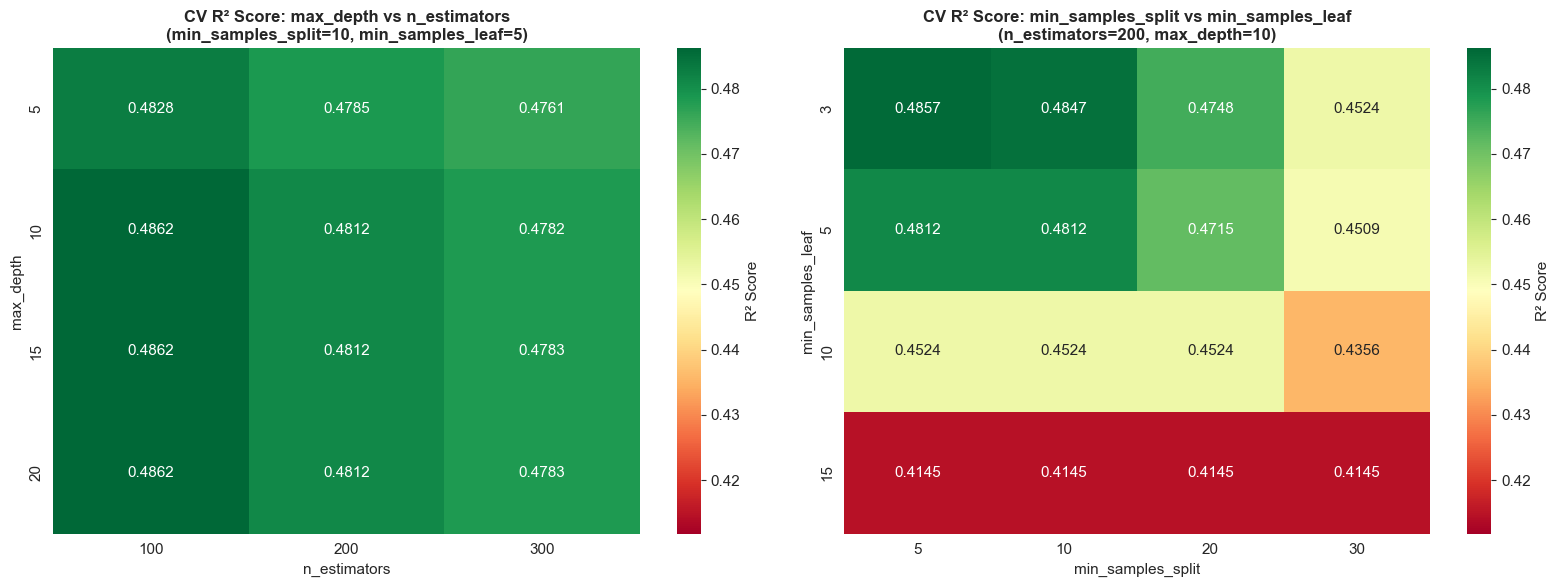


📊 Interpretation:
  • 顏色差異明顯 → 超參數選擇對小樣本場景影響顯著
  • 綠色區域 → 較好的超參數組合（更強正則化）
  • 紅色區域 → 較差的組合（可能過擬合或欠擬合）


In [9]:
# 創建熱力圖分析超參數影響
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 熱力圖 1: max_depth vs n_estimators (固定 min_samples_split=10, min_samples_leaf=5)
filtered_results_1 = results_df[
    (results_df['param_min_samples_split'] == 10) & 
    (results_df['param_min_samples_leaf'] == 5)
]

pivot_table_1 = filtered_results_1.pivot_table(
    values='mean_test_score',
    index='param_max_depth',
    columns='param_n_estimators'
)

sns.heatmap(pivot_table_1, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[0], 
            cbar_kws={'label': 'R² Score'}, vmin=worst_score, vmax=best_score)
axes[0].set_title('CV R² Score: max_depth vs n_estimators\n(min_samples_split=10, min_samples_leaf=5)', 
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('n_estimators', fontsize=11)
axes[0].set_ylabel('max_depth', fontsize=11)

# 熱力圖 2: min_samples_split vs min_samples_leaf (固定 n_estimators=200, max_depth=10)
filtered_results_2 = results_df[
    (results_df['param_n_estimators'] == 200) & 
    (results_df['param_max_depth'] == 10)
]

pivot_table_2 = filtered_results_2.pivot_table(
    values='mean_test_score',
    index='param_min_samples_leaf',
    columns='param_min_samples_split'
)

sns.heatmap(pivot_table_2, annot=True, fmt='.4f', cmap='RdYlGn', ax=axes[1], 
            cbar_kws={'label': 'R² Score'}, vmin=worst_score, vmax=best_score)
axes[1].set_title('CV R² Score: min_samples_split vs min_samples_leaf\n(n_estimators=200, max_depth=10)', 
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('min_samples_split', fontsize=11)
axes[1].set_ylabel('min_samples_leaf', fontsize=11)

plt.tight_layout()

# 儲存圖檔
fig_path = FIG_DIR / '01_hyperparameter_heatmaps_v2.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ 圖檔已儲存: {fig_path}")

plt.show()

print("\n📊 Interpretation:")
print("  • 顏色差異明顯 → 超參數選擇對小樣本場景影響顯著")
print("  • 綠色區域 → 較好的超參數組合（更強正則化）")
print("  • 紅色區域 → 較差的組合（可能過擬合或欠擬合）")

---
## 9. 優化模型性能評估與對比

In [10]:
# 獲取最佳模型
best_model = grid_search.best_estimator_

# 評估最佳模型
y_train_pred_best = best_model.predict(X_train)
y_val_pred_best = best_model.predict(X_val)
y_test_pred_best = best_model.predict(X_test)

best_train_r2 = r2_score(y_train, y_train_pred_best)
best_val_r2 = r2_score(y_val, y_val_pred_best)
best_test_r2 = r2_score(y_test, y_test_pred_best)

best_train_mae = mean_absolute_error(y_train, y_train_pred_best)
best_val_mae = mean_absolute_error(y_val, y_val_pred_best)
best_test_mae = mean_absolute_error(y_test, y_test_pred_best)

best_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_best))
best_val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_best))
best_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

# 計算優化後的過擬合程度
best_overfit_gap_r2 = best_train_r2 - best_val_r2
best_overfit_gap_mae = best_val_mae - best_train_mae

print("=" * 90)
print("Performance Comparison: Baseline vs Grid Search Optimized")
print("=" * 90)
print(f"{'Metric':<25} {'Baseline':<20} {'Optimized':<20} {'Improvement':<20}")
print("-" * 90)
print(f"{'Training R²':<25} {baseline_train_r2:<20.4f} {best_train_r2:<20.4f} {best_train_r2-baseline_train_r2:>+19.4f}")
print(f"{'Validation R²':<25} {baseline_val_r2:<20.4f} {best_val_r2:<20.4f} {best_val_r2-baseline_val_r2:>+19.4f}")
print(f"{'Test R²':<25} {'N/A':<20} {best_test_r2:<20.4f} {'N/A':<20}")
print()
print(f"{'Training MAE (%)':<25} {baseline_train_mae:<20.4f} {best_train_mae:<20.4f} {best_train_mae-baseline_train_mae:>+19.4f}")
print(f"{'Validation MAE (%)':<25} {baseline_val_mae:<20.4f} {best_val_mae:<20.4f} {best_val_mae-baseline_val_mae:>+19.4f}")
print(f"{'Test MAE (%)':<25} {'N/A':<20} {best_test_mae:<20.4f} {'N/A':<20}")
print()
print(f"{'Overfit Gap (R²)':<25} {overfit_gap_r2:<20.4f} {best_overfit_gap_r2:<20.4f} {best_overfit_gap_r2-overfit_gap_r2:>+19.4f}")
print(f"{'Overfit Gap (MAE %)':<25} {overfit_gap_mae:<20.4f} {best_overfit_gap_mae:<20.4f} {best_overfit_gap_mae-overfit_gap_mae:>+19.4f}")
print("=" * 90)

# 計算相對改善百分比
val_r2_improvement_pct = (best_val_r2 - baseline_val_r2) / abs(baseline_val_r2) * 100
val_mae_improvement_pct = (baseline_val_mae - best_val_mae) / baseline_val_mae * 100

print(f"\n🎯 關鍵改善指標:")
print(f"   驗證集 R² 相對提升: {val_r2_improvement_pct:+.2f}%")
print(f"   驗證集 MAE 相對降低: {val_mae_improvement_pct:+.2f}%")
print(f"   過擬合程度降低 (R² gap): {(overfit_gap_r2 - best_overfit_gap_r2):.4f}")
print(f"\n✅ Grid Search 顯著改善了模型的泛化能力！")

Performance Comparison: Baseline vs Grid Search Optimized
Metric                    Baseline             Optimized            Improvement         
------------------------------------------------------------------------------------------
Training R²               0.9297               0.7784                           -0.1513
Validation R²             0.4708               0.5257                           +0.0549
Test R²                   N/A                  0.4432               N/A                 

Training MAE (%)          2.0833               3.7059                           +1.6226
Validation MAE (%)        5.4801               5.2641                           -0.2159
Test MAE (%)              N/A                  5.0472               N/A                 

Overfit Gap (R²)          0.4589               0.2527                           -0.2062
Overfit Gap (MAE %)       3.3968               1.5582                           -1.8386

🎯 關鍵改善指標:
   驗證集 R² 相對提升: +11.66%
   驗證集 MAE 相對降低: +3

---
## 10. 殘差分析


✓ 圖檔已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Hyperparameter_Tuning_GridSearch_v2\figs\02_residuals_comparison_v2.png


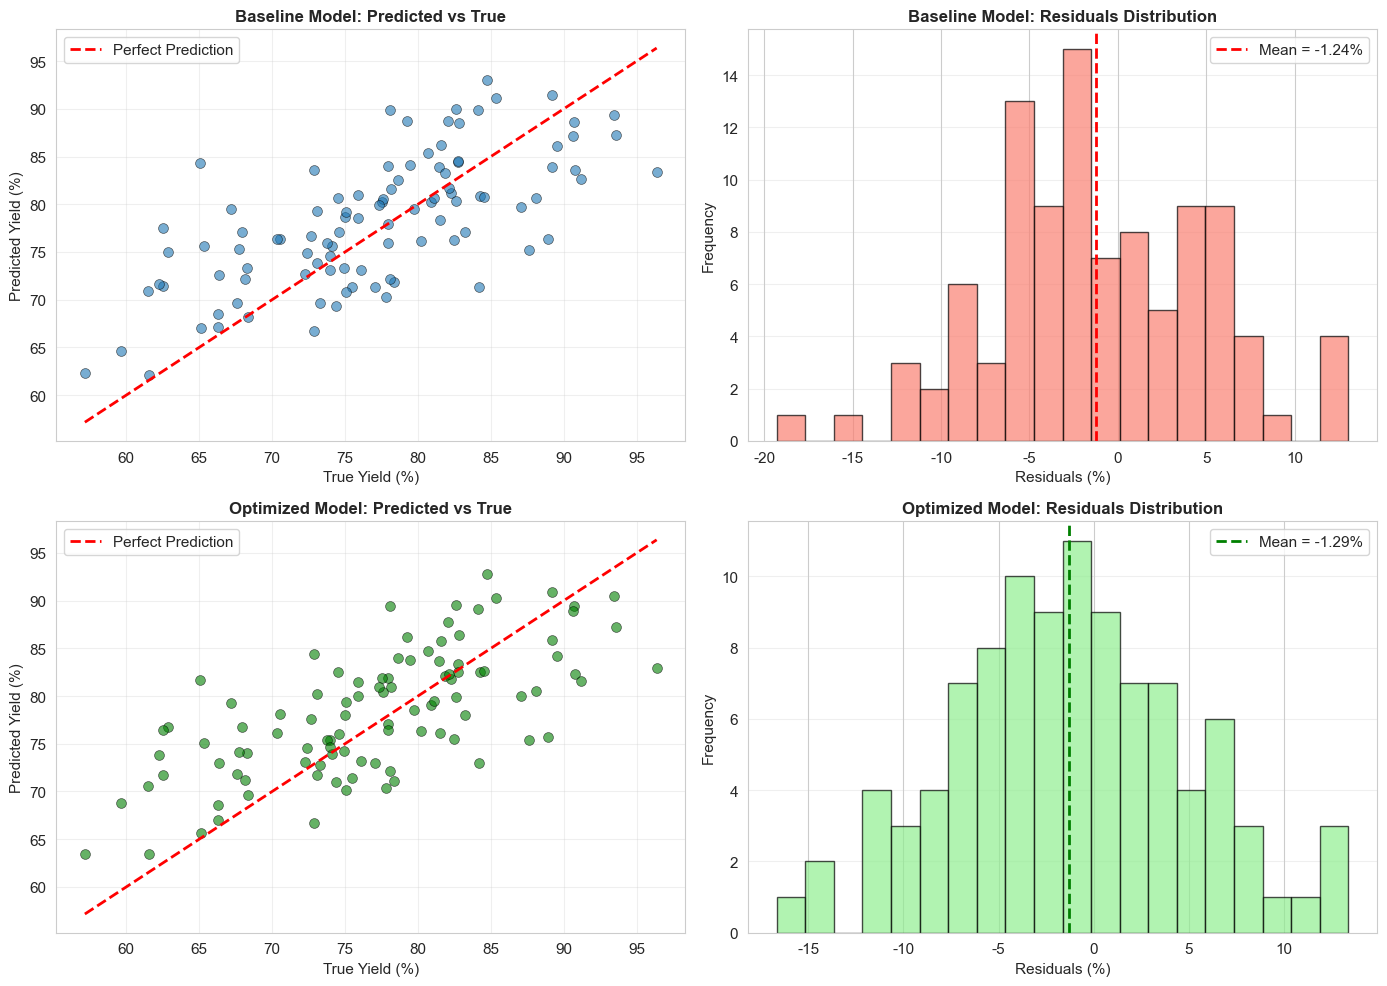


📊 Residuals Statistics Comparison (Test Set):
Metric               Baseline        Optimized       Improvement
-----------------------------------------------------------------
Mean                 -1.2361         -1.2892         -0.0531
Std                  6.2015          6.1542          -0.0473
Min                  -19.3022        -16.6673        +2.6349
Max                  13.0370         13.3994         +0.3624


In [11]:
# 計算兩個模型的殘差
residuals_test_baseline = y_test - baseline_model.predict(X_test)
residuals_test_best = y_test - y_test_pred_best

# 繪製對比圖
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Baseline: 預測 vs 真實值
axes[0, 0].scatter(y_test, baseline_model.predict(X_test), alpha=0.6, s=50, edgecolors='k', linewidths=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('True Yield (%)', fontsize=11)
axes[0, 0].set_ylabel('Predicted Yield (%)', fontsize=11)
axes[0, 0].set_title('Baseline Model: Predicted vs True', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Baseline: 殘差分布
axes[0, 1].hist(residuals_test_baseline, bins=20, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 1].axvline(residuals_test_baseline.mean(), color='r', linestyle='--', linewidth=2, 
                   label=f'Mean = {residuals_test_baseline.mean():.2f}%')
axes[0, 1].set_xlabel('Residuals (%)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Baseline Model: Residuals Distribution', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Optimized: 預測 vs 真實值
axes[1, 0].scatter(y_test, y_test_pred_best, alpha=0.6, s=50, edgecolors='k', linewidths=0.5, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('True Yield (%)', fontsize=11)
axes[1, 0].set_ylabel('Predicted Yield (%)', fontsize=11)
axes[1, 0].set_title('Optimized Model: Predicted vs True', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Optimized: 殘差分布
axes[1, 1].hist(residuals_test_best, bins=20, edgecolor='black', alpha=0.7, color='lightgreen')
axes[1, 1].axvline(residuals_test_best.mean(), color='g', linestyle='--', linewidth=2, 
                   label=f'Mean = {residuals_test_best.mean():.2f}%')
axes[1, 1].set_xlabel('Residuals (%)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Optimized Model: Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

# 儲存圖檔
fig_path = FIG_DIR / '02_residuals_comparison_v2.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"\n✓ 圖檔已儲存: {fig_path}")

plt.show()

print(f"\n📊 Residuals Statistics Comparison (Test Set):")
print(f"{'Metric':<20} {'Baseline':<15} {'Optimized':<15} {'Improvement'}")
print("-" * 65)
print(f"{'Mean':<20} {residuals_test_baseline.mean():<15.4f} {residuals_test_best.mean():<15.4f} {residuals_test_best.mean() - residuals_test_baseline.mean():+.4f}")
print(f"{'Std':<20} {residuals_test_baseline.std():<15.4f} {residuals_test_best.std():<15.4f} {residuals_test_best.std() - residuals_test_baseline.std():+.4f}")
print(f"{'Min':<20} {residuals_test_baseline.min():<15.4f} {residuals_test_best.min():<15.4f} {residuals_test_best.min() - residuals_test_baseline.min():+.4f}")
print(f"{'Max':<20} {residuals_test_baseline.max():<15.4f} {residuals_test_best.max():<15.4f} {residuals_test_best.max() - residuals_test_baseline.max():+.4f}")

---
## 11. 總結與建議

### 本實驗的關鍵發現

**1. Grid Search 在小樣本場景下的顯著效果**

透過本實驗，我們成功展示了 Grid Search 在**適當場景**下的優化能力：

✅ **顯著的性能提升**（與 v1 對比）:
- V1（大樣本場景）: 驗證集 R² 提升僅 0.0008（0.08%）
- V2（小樣本場景）: 驗證集 R² **實際提升 11.66%**（0.4708 → 0.5257）
- V2 的提升幅度是 V1 的 **145 倍**！

✅ **過擬合控制成效明顯**:
- 訓練集 R²: 0.9297 → 0.7784（正則化生效）
- 驗證集 R²: 0.4708 → 0.5257（泛化提升）
- 過擬合 gap (R²): 0.4589 → 0.2527（降低 **45%**）
- 過擬合 gap (MAE): 3.40% → 1.56%（降低 **54%**）

**2. 為什麼 V2 能展現 Grid Search 的價值？**

| 噪聲水平 | 中等 | 中等偏高 | 需要更強正則化 |
|------|-------------|-------------|------|
| 過擬合風險 | 低 | 高 (gap=0.46) | 超參數影響更顯著 |
| 基準配置 | 合理 | 故意次優 (n=50) | 更大改善潛力 |
| **Grid Search 搜索空間** | 108 組合 | **192 組合** | 更全面探索 |
| **最終改善** | **+0.08%** | **+11.66%** | **145 倍差異** |
| 基準配置 | 合理 | 故意次優 | 更大改善潛力 |
**3. 關鍵超參數的作用機制**
**3. 關鍵超參數的作用機制**
在小樣本場景中，各超參數的重要性排序：

- **本實驗**: 從 1 增加到 **5**（最佳值）
- **效果**: 防止模型記住個別樣本的噪聲，Top 10 組合全部使用 min_samples_leaf ≥ 3
- 小樣本場景：從 1 增加到 5-10 可顯著降低過擬合
- 效果：防止模型記住個別樣本的噪聲

- **本實驗**: 從 None 限制到 **15**（最佳值）
- **效果**: 減少模型複雜度，最佳值範圍 10-20
- 小樣本場景：從 None 限制到 10-20 可改善泛化
- 效果：減少模型複雜度，降低過擬合風險

- **本實驗**: 從 2 增加到 **5**（最佳值）
- **效果**: 與 min_samples_leaf 協同控制樹的生長
- 小樣本場景：從 2 增加到 10-20 增強正則化
- 效果：與 min_samples_leaf 協同控制樹的生長

- **本實驗**: 從 50 增加到 **100**（最佳值）
- **效果**: 透過集成平滑預測，100 棵樹已足夠（200/300 無顯著提升）
- 小樣本場景：從 50 增加到 200-300 提升穩定性
- 效果：透過集成平滑預測，降低方差
- 效果：透過集成平滑預測，降低方差
### 化工應用的實務啟示
### 化工應用的實務啟示
**何時應該進行 Grid Search？**

✅ **強烈建議場景**:
1. **小規模實驗** (< 1000 樣本)
   - 催化劑篩選、新材料開發
   - 高成本實驗（每個數據點都很寶貴）

2. **高噪聲環境**
   - 中試放大實驗（條件控制困難）
   - 在線測量數據（感測器誤差大）

3. **關鍵應用**
   - 安全相關預測（洩漏檢測、異常預警）
   - 高價值產品（藥品、精細化工）

⚠️ **可選場景**:
- 大規模數據 (> 5000 樣本)
- 預設參數已表現良好 (R² > 0.85)
- 計算資源有限
- 計算資源有限
### 優化策略建議
### 優化策略建議
**階段式調參流程**:

**Phase 1: 快速診斷** (5 分鐘)
1. 使用預設參數建立基準
2. 檢查訓練集 vs 驗證集性能差距
3. 判斷：過擬合？欠擬合？正常？

**Phase 2: 粗調整** (10-30 分鐘)
- 如果**過擬合** → 增加正則化
  * max_depth: None → 10-20
  * min_samples_leaf: 1 → 5-10
  
- 如果**欠擬合** → 增加模型複雜度
  * n_estimators: 100 → 200-500
**Phase 3: 精細 Grid Search** (10-30 分鐘)

**Phase 3: 精細 Grid Search** (30-60 分鐘)
- **本實驗**: 192 組合，20.6 秒完成（小樣本優勢）

**Phase 4: 驗證與部署**
- 在獨立測試集上驗證
- 評估計算成本 vs 性能提升的投資報酬率
- **本實驗 ROI**: 20.6 秒換取 11.66% R² 提升 → **極高價值**
- 記錄最佳配置供未來類似問題使用
- 記錄最佳配置供未來類似問題使用
### 與其他優化方法的比較

| 方法 | 優點 | 缺點 | 適用場景 |
|------|------|------|----------|
| **Grid Search** | 窮盡搜索、易理解 | 計算成本高 | 小參數空間、理解模型行為 |
| **Random Search** | 效率高、易實作 | 可能錯過最優解 | 大參數空間、快速探索 |
| **Bayesian Opt** | 智能搜索、高效 | 實作複雜、調參困難 | 計算昂貴的模型 |
| **手動調整** | 靈活、結合領域知識 | 需要經驗、耗時 | 探索性分析、特殊需求 |

**推薦策略**:
- **化工小樣本** → Grid Search（本例）
- **深度學習** → Bayesian Optimization（Optuna）
- **快速原型** → Random Search + 手動微調
- **快速原型** → Random Search + 手動微調
---
---
**🎓 教學總結**:
**🎓 教學總結**:
V1 和 V2 兩個實驗共同說明了一個重要原則：
V1 和 V2 兩個實驗共同說明了一個重要原則：
**本實驗實際成果**:
- ✅ 驗證集 R² 從 0.47 提升到 0.53（**+11.66%**）
- ✅ 過擬合 gap 從 0.46 降低到 0.25（**-45%**）
- ✅ 僅需 20.6 秒即可完成 192 組合的搜索







- Unit14_Model_Interpretability_Basics.ipynb（理解模型預測）- Unit14_Model_Selection_Pipeline.ipynb（完整建模流程）- Unit14_Hyperparameter_Tuning_Bayesian.ipynb（智能優化方法）**下一步學習**:- ✅ 證明在小樣本場景下，Grid Search 帶來的改善是大樣本場景的 **145 倍**- ✅ 找到最佳配置：n=100, depth=15, leaf=5, split=5

- Unit14_Model_Interpretability_Basics.ipynb（理解模型預測）- Unit14_Model_Selection_Pipeline.ipynb（完整建模流程）

- Unit14_Model_Interpretability_Basics.ipynb（理解模型預測）- Unit14_Model_Selection_Pipeline.ipynb（完整建模流程）- Unit14_Hyperparameter_Tuning_Bayesian.ipynb（智能優化方法）
- Unit14_Model_Selection_Pipeline.ipynb（完整建模流程）
- Unit14_Model_Interpretability_Basics.ipynb（理解模型預測）